<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Demo-fitting-the-HDFN-catalog-provided-with-the-original-EAZY-code" data-toc-modified-id="Demo-fitting-the-HDFN-catalog-provided-with-the-original-EAZY-code-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Demo fitting the HDFN catalog provided with the original EAZY code</a></span><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Iterative-zeropoint-corrections" data-toc-modified-id="Iterative-zeropoint-corrections-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Iterative zeropoint corrections</a></span></li><li><span><a href="#Now-fit-the-whole-catalog" data-toc-modified-id="Now-fit-the-whole-catalog-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Now fit the whole catalog</a></span></li></ul></li></ul></div>

### Demo fitting the HDFN catalog provided with the original EAZY code

In [1]:
%matplotlib inline

In [2]:
# Do I need to install on, e.g., mybinder?
import os
orig_wd = os.getcwd()

try:
    import eazy
    HAS_EAZY = True
except:
    HAS_EAZY = False

if ('jovyan' in orig_wd):
    if not HAS_EAZY:
        print('Install on /home/jovyan')

        os.chdir('/home/jovyan')
        !pip install . 

        os.chdir(orig_wd)
    
    try:
        print('EAZYCODE = '+os.getenv('EAZYCODE'))
    except:
        %env EAZYCODE=/home/jovyan/eazy-photoz/
    

In [3]:
# Module versions
import importlib
import sys

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy', 'prospect']:
    #print(module)
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))


3.6.10 |Anaconda, Inc.| (default, May  7 2020, 23:06:31) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]

               numpy : 1.19.1
               scipy : 1.5.0
          matplotlib : 3.2.2
             astropy : 4.0.1.post1
                eazy : 0.4-40-gd1eb564
            prospect : 1.0.0


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

import eazy

# Symlink templates & filters from the eazy-code repository
try:
    print('EAZYCODE = '+os.getenv('EAZYCODE'))
except:
    pass

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs() 

EAZYCODE = /usr/local/share/python/eazy-photoz/


In [5]:
# quiet numpy/astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

#### Parameters

Default parameters are stored in the file `eazy/data/zphot.param.default` in the repository.

Parameter that differ from defaults can be provided in a dictionary as follows.

In [6]:
params = {}
params['CATALOG_FILE'] = os.path.join(os.getenv('EAZYCODE'), 'inputs/hdfn_fs99_eazy.cat')

params['MAIN_OUTPUT_FILE'] = 'hdfn.eazypy'

# Galactic extinction
params['MW_EBV'] = 0.0103

params['Z_STEP'] = 0.01
params['Z_MIN'] = 0.01
params['Z_MAX'] = 6.

params['PRIOR_ABZP'] = 25 
params['PRIOR_FILTER'] = 28 # K
params['PRIOR_FILE'] = 'templates/prior_K_TAO.dat'

params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'

params['FIX_ZSPEC'] = False

In [7]:
translate_file = os.path.join(os.getenv('EAZYCODE'), 'inputs/zphot.translate')
self = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, zeropoint_file=None, 
                          params=params, load_prior=True, load_products=False)

Read default param file: /Users/gbrammer/miniconda3/envs/grizli-dev-2020.1/lib/python3.6/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /usr/local/share/python/eazy-photoz/inputs/hdfn_fs99_eazy.cat
   >>> NOBJ = 1067
f_f300w e_f300w ( 10): hst/wfpc2_f300w.dat
f_f450w e_f450w ( 12): hst/wfpc2_f450w.dat
f_f606w e_f606w ( 14): hst/wfpc2_f606w.dat
f_f814w e_f814w ( 16): hst/wfpc2_f814w.dat
f_irimj e_irimj ( 26): KPNO/IRIMJ
f_irimh e_irimh ( 27): KPNO/IRIMH
f_irimk e_irimk ( 28): KPNO/IRIMK
Read PRIOR_FILE:  templates/prior_K_TAO.dat
Template grid: templates/fsps_full/tweak_fsps_QSF_12_v3.param (this may take some time)
Process template tweak_fsps_QSF_12_v3_001.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_002.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_003.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_004.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_005.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3_006.dat (NZ=1).
Process template tweak_fsps_QSF_12_v3

194it [00:00, 6007.30it/s]


#### Iterative zeropoint corrections

Iteration:  0
Compute best fits
fit_best: 0.2 s (n_proc=1,  NOBJ=637)
Fit 1.8 s (n_proc=8, NOBJ=645)
Iterative correction - zeropoint / template
Iteration:  1
Compute best fits
fit_best: 0.2 s (n_proc=1,  NOBJ=638)
Fit 2.0 s (n_proc=8, NOBJ=645)
`error_residuals`: force uncertainties to match residuals
Iterative correction - zeropoint / template
Iteration:  2
Compute best fits
fit_best: 0.2 s (n_proc=1,  NOBJ=636)
Fit 2.0 s (n_proc=8, NOBJ=643)
`error_residuals`: force uncertainties to match residuals
Iterative correction - zeropoint / template


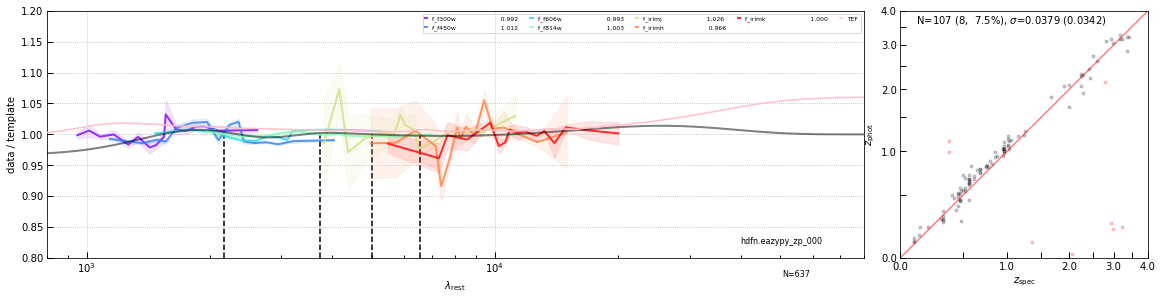

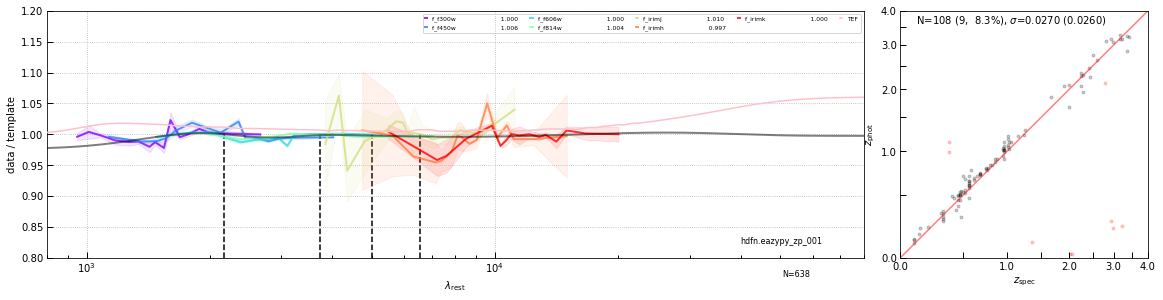

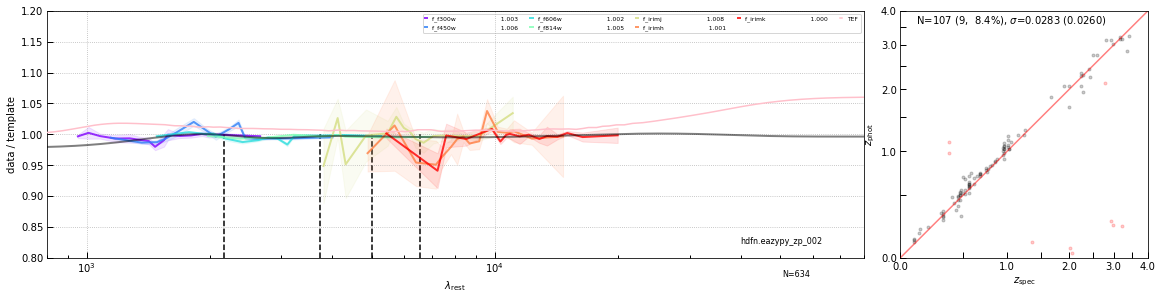

In [8]:
NITER = 3
NBIN = np.minimum(self.NOBJ//100, 180)

self.param.params['VERBOSITY'] = 1.
for iter in range(NITER):
    print('Iteration: ', iter)
    
    sn = self.fnu/self.efnu
    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False, 
                              update_zeropoints=True, iter=iter, n_proc=8, 
                              save_templates=False, error_residuals=(iter > 0), 
                              NBIN=NBIN, get_spatial_offset=False)

#### Now fit the whole catalog

In [9]:
# Turn off error corrections derived above
self.efnu = self.efnu_orig*1

# Full catalog
sample = np.isfinite(self.cat['z_spec'])

self.fit_parallel(self.idx[sample], n_proc=8)

Compute best fits
fit_best: 0.2 s (n_proc=1,  NOBJ=1014)
Fit 3.2 s (n_proc=8, NOBJ=1067)


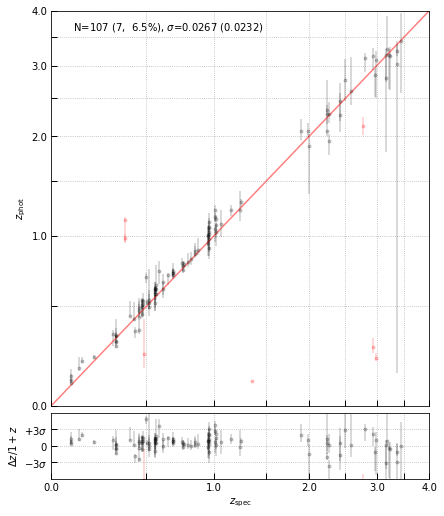

In [10]:
# Show zspec-zphot comparison
fig = self.zphot_zspec()

In [11]:
# Derived parameters (z params, RF colors, masses, SFR, etc.)
zout, hdu = self.standard_output(rf_pad_width=0.5, rf_max_err=2, 
                                 prior=True, beta_prior=True)

# 'zout' also saved to [MAIN_OUTPUT_FILE].zout.fits

Get best fit coeffs & best redshifts
fit_best: 0.5 s (n_proc=1,  NOBJ=1047)
Get parameters (UBVJ=[153, 154, 155, 161], LIR=[8, 1000])


/Users/gbrammer/miniconda3/envs/grizli-dev-2020.1/lib/python3.6/site-packages/eazy/photoz.py:4608: RuntimeWarning: covariance is not positive-semidefinite.
  coeffs_draw[:, ok_temp] = np.random.multivariate_normal(coeffs_i[ok_temp], covar, size=get_err)


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


Text(0, 0.5, '$(U-V)_0$')

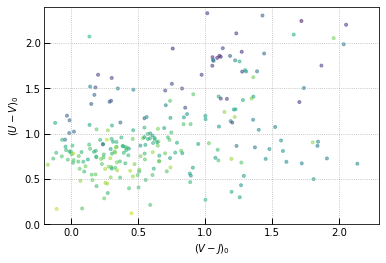

In [12]:
# Show UVJ diagram
uv = -2.5*np.log10(zout['restU']/zout['restV'])
vj = -2.5*np.log10(zout['restV']/zout['restJ'])
ssfr = zout['sfr']/zout['mass']

sel = (zout['z_phot'] > 0.2) & (zout['z_phot'] < 1)
plt.scatter(vj[sel], uv[sel], c=np.log10(ssfr)[sel], 
            vmin=-13, vmax=-8, alpha=0.5)

plt.xlim(-0.2, 2.3); plt.ylim(0, 2.4); plt.grid()
plt.xlabel(r'$(V-J)_0$'); plt.ylabel(r'$(U-V)_0$')    

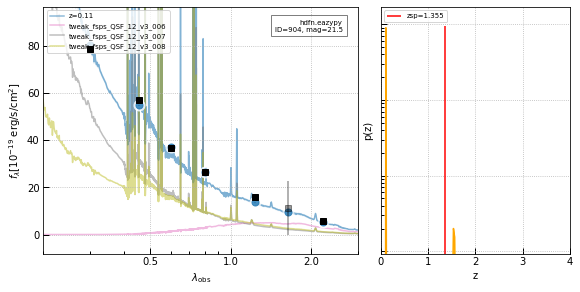

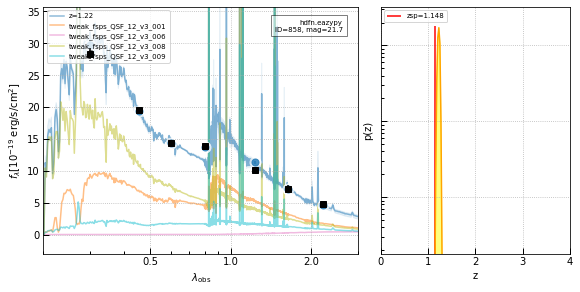

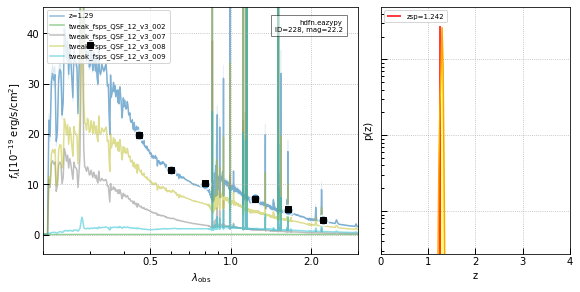

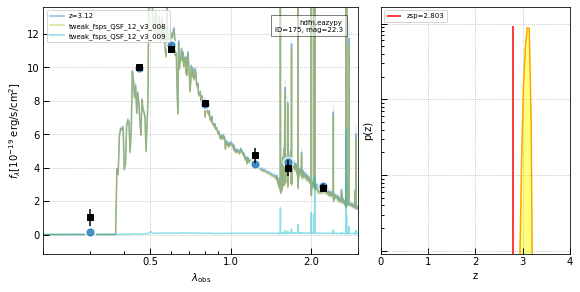

In [13]:
# Show brightest objects with z_spec > 1
imag = params['PRIOR_ABZP'] - 2.5*np.log10(self.cat['f_f814w'])
sel = (self.cat['z_spec'] > 1.1)

so = np.argsort(imag[sel])
ids = self.cat['id'][sel][so]

for i in range(4):
    fig, data = self.show_fit(ids[i], xlim=[0.2, 3], show_components=True,
                              logpz=True, zr=[0,4])

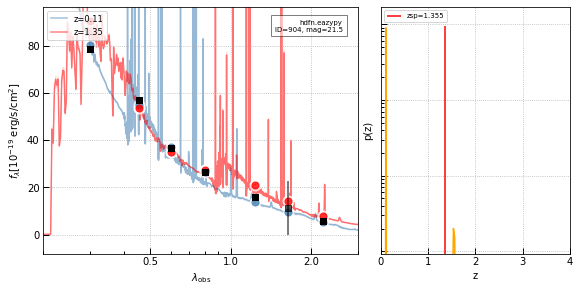

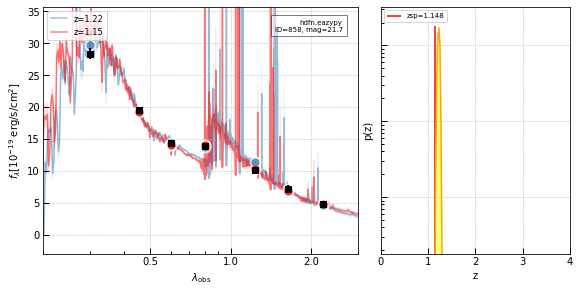

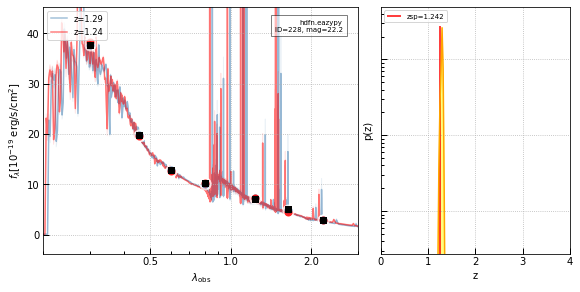

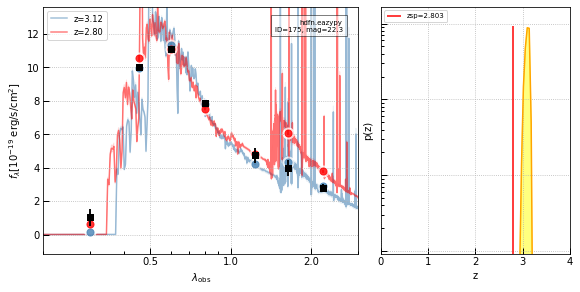

In [14]:
# Compare forced fit at z_spec
for i in range(4):
    ix = np.where(self.cat['id'] == ids[i])[0][0]
    fig, data = self.show_fit(ids[i], xlim=[0.2, 3], 
                        show_components=False,
                        template_color='steelblue', logpz=True, zr=[0,4])

    # Now show with z_spec
    axes = fig.axes[:1]
    res = self.show_fit(ids[i], xlim=[0.2, 3], axes=axes,
                        zshow=self.cat['z_spec'][ix], 
                        show_components=False,
                        template_color='r')

    axes[0].legend(loc='upper left')

In [15]:
zout.meta

OrderedDict([('version', ('0.4-40-gd1eb564', 'Eazy-py version')),
             ('prior', (True, 'Prior applied (templates/prior_K_TAO.dat)')),
             ('betprior', (True, 'Beta prior applied')),
             ('fitter', ('nnls', 'Optimization method for template fits')),
             ('SYS_ERR', 0.01),
             ('TEMP_ERR_FILE', 'templates/uvista_nmf/template_error_10.def'),
             ('TEMP_ERR_A2', 0.2),
             ('PRIOR_FILTER', 28),
             ('PRIOR_ABZP', 25),
             ('IGM_SCALE_TAU', 1.4),
             ('APPLY_IGM', 'y'),
             ('TEMPLATES_FILE',
              'templates/fsps_full/tweak_fsps_QSF_12_v3.param'),
             ('TEMPL000', 'tweak_fsps_QSF_12_v3_001.dat'),
             ('TEMPL001', 'tweak_fsps_QSF_12_v3_002.dat'),
             ('TEMPL002', 'tweak_fsps_QSF_12_v3_003.dat'),
             ('TEMPL003', 'tweak_fsps_QSF_12_v3_004.dat'),
             ('TEMPL004', 'tweak_fsps_QSF_12_v3_005.dat'),
             ('TEMPL005', 'tweak_fsps_QSF_12_v3_0

In [16]:
zout.colnames

['id',
 'z_spec',
 'nusefilt',
 'lc_min',
 'lc_max',
 'z_phot',
 'z_phot_chi2',
 'z_phot_risk',
 'z_min_risk',
 'min_risk',
 'z_raw_chi2',
 'raw_chi2',
 'z025',
 'z160',
 'z500',
 'z840',
 'z975',
 'restU',
 'restU_err',
 'restB',
 'restB_err',
 'restV',
 'restV_err',
 'restJ',
 'restJ_err',
 'dL',
 'mass',
 'sfr',
 'Lv',
 'LIR',
 'MLv',
 'Av',
 'mass_p',
 'sfr_p',
 'Lv_p',
 'LIR_p',
 'ssfr_p',
 'rest270',
 'rest270_err',
 'rest274',
 'rest274_err',
 'rest120',
 'rest120_err',
 'rest121',
 'rest121_err',
 'rest156',
 'rest156_err',
 'rest157',
 'rest157_err',
 'rest158',
 'rest158_err',
 'rest159',
 'rest159_err',
 'rest160',
 'rest160_err',
 'rest161',
 'rest161_err',
 'rest162',
 'rest162_err',
 'rest163',
 'rest163_err',
 'DISTMOD',
 'ABSM_271',
 'ABSM_272',
 'ABSM_274']